# FDMT efficiency
The current FDMT seems to be a bit inefficient - i.e. we do the FDMT of a pulse and the peak in the FDMT should be the sum of the pulse - and it's not. Worrying.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
from craft import fdmt # you'll need to have ../python in  you PYTHONPATH
import simfrb # in same directory as fdmt
from pylab import *

In [2]:
nf = 256 # number of channels - non-power-of-2 - naughty naughty!
fmax = 1440. #  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 512 # Number of DM trials to do
nt = 512 # Number of samples per block
tsamp = 1.0 # milliseconds

In [3]:
def mysimfrb(fmin, df, nf, tsamp, idt, nt, offset, width=0):
    assert df > 0
    assert nf > 0
    assert fmin > 0
    d = np.zeros((nf, nt))
    fmax = fmin + nf*df
    fmin /= 1e3
    fmax /= 1e3
    df /= 1e3
    dm1 = 4.15*(fmin**-2 - fmax**-2)
    dm = idt*tsamp/dm1
    
    assert dm1> 0
    
    for c in range(nf):
        f2 = fmin + c*df       
        offset_ms = -4.15*dm*(fmax**-2 - f2**-2) + offset
        offset_samp = int(np.round(offset_ms/tsamp)) 
        #print c, f2, fmax, offset_ms, offset_samp
        d[c, offset_samp] = 1
    return d

In [5]:
def checkhit(thefdmt, dm, offset=0):
    # I haven't had time to tidy this up - the untis are funny and the FRB is updside down and transposed
    # With respect to what the FDMT wants to see - just trust me OK.
    # Caution: The DM units here are in pc/cm3 and the DM units the FDMT uses are in samples. at about 1 GHz and 1 ms these are almost identical.
    #frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=dm, ntimes=nt, offset=10).T
    #frb = np.flipud(frb)
    frb = mysimfrb(fmin, df, nf, tsamp, dm, nt, offset=offset)
    fout = thefdmt(frb)
    hitting_efficiency = fout.max()/frb.sum() # should be close to 1. Ideally 1.
    maxidx = fout.argmax()
    idtmax, tmax = np.unravel_index(maxidx, fout.shape)
    dm_of_idt = idtmax*tsamp/(4.15*((fmin/1e3)**-2 - (fmax/1e3)**-2)) # convert idt to pc/cm3
    #print 'Hitting efficiency', hitting_efficiency, 'Maximum at t=', tmax, 'idt=', idtmax, '=', dm_of_idt, 'pc/cm3'
    
    return (hitting_efficiency, idtmax, tmax)

In [6]:
thefdmt = fdmt.Fdmt( fmin, df, nf, nd, nt) # make FDMT
dmrange = np.arange(0, 300, 10)
hitdata = []
for dm in dmrange:
    hitdata.append(checkhit(thefdmt, dm, offset=10))
    
hitdata = np.array(hitdata)    

<IPython.core.display.Javascript object>


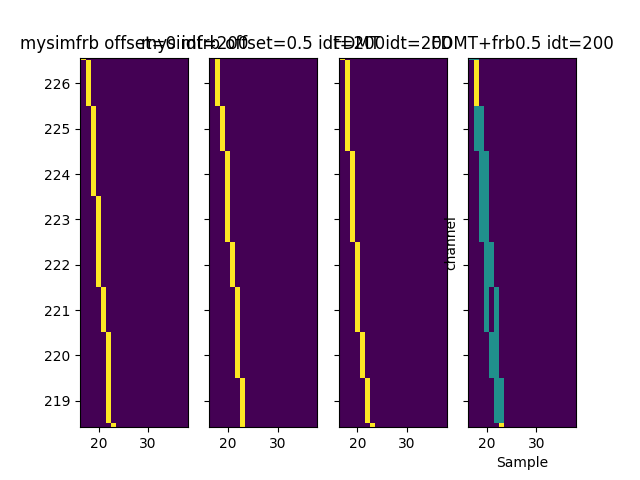

Text(0, 0.5, 'channel')

In [17]:
idt = 200



frb1 = mysimfrb(fmin, df, nf, tsamp, idt, nt, offset=0)
frb2 = mysimfrb(fmin, df, nf, tsamp, idt, nt, offset=0.5)
frbfdmt = np.zeros((nf, nt))
frbfdmt = thefdmt.add_frb_track(idt,frbfdmt)


fig, ax = subplots(1,4, sharex=True, sharey=True)
ax[0].imshow(frb1, aspect='auto', origin='lower', interpolation='nearest')
ax[0].set_title(f'mysimfrb offset=0 idt={idt}')

ax[1].imshow(frb2, aspect='auto', origin='lower', interpolation='nearest')
ax[1].set_title(f'mysimfrb offset=0.5 idt={idt}')

ax[2].imshow(frbfdmt, aspect='auto', origin='lower', interpolation='nearest')
ax[2].set_title(f'FDMT idt={idt}')

ax[3].imshow(frbfdmt+frb2, aspect='auto', origin='lower', interpolation='nearest')
ax[3].set_title(f'FDMT+frb0.5 idt={idt}')




xlabel('Sample')
ylabel('channel')

In [18]:
hitdata.shape

(30, 3)

<IPython.core.display.Javascript object>


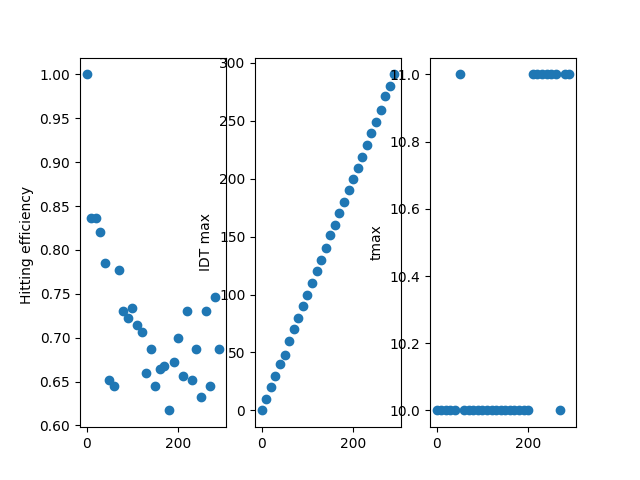

Text(0, 0.5, 'tmax')

In [19]:
fig, ax = subplots(1,3, sharex=True)
ax[0].plot(dmrange, hitdata[:, 0], 'o')
ax[0].set_ylabel('Hitting efficiency ')
ax[1].plot(dmrange, hitdata[:, 1], 'o')
ax[1].set_ylabel('IDT max')
ax[2].plot(dmrange, hitdata[:, 2] - hitdata[:, 1], 'o')
ax[2].set_ylabel('tmax')

In [25]:
dm = 7
frb = mysimfrb(fmin, df, nf, tsamp, dm, nt, offset=10)
fout = thefdmt(frb)

<IPython.core.display.Javascript object>


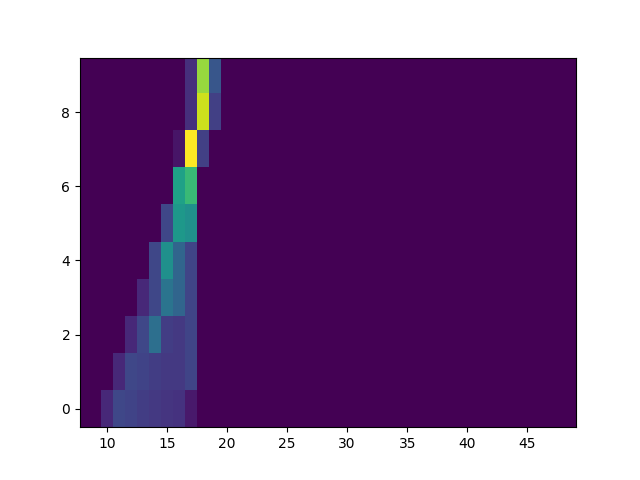

In [28]:
figure()
imshow(fout, aspect='auto', origin='lower')

<IPython.core.display.Javascript object>


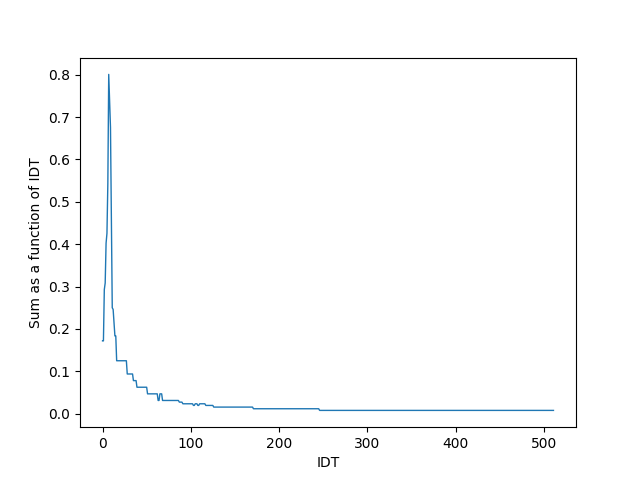

Text(0, 0.5, 'Sum as a function of IDT')

In [33]:
figure()
plot(fout.max(axis=1)/frb.sum())
xlabel('IDT')
ylabel('Sum as a function of IDT')

In [30]:
frb.sum()

256.0

In [34]:
number_of_sums = thefdmt(np.ones((nf,nt)))

<IPython.core.display.Javascript object>


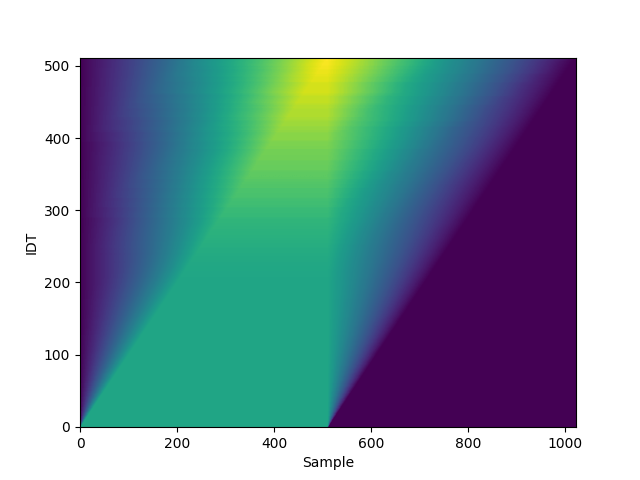

Text(0, 0.5, 'IDT')

In [37]:
figure()
imshow(number_of_sums, aspect='auto', origin='lower')
xlabel('Sample')
ylabel('IDT')

<IPython.core.display.Javascript object>


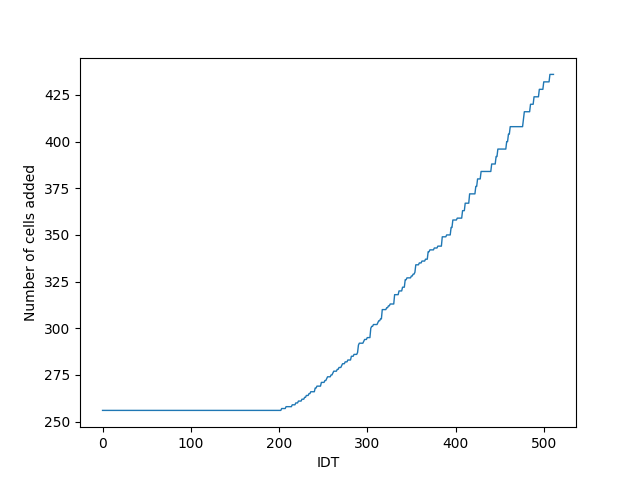

Text(0, 0.5, 'Number of cells added')

In [39]:
figure()
plot(number_of_sums[:,511])
xlabel('IDT')
ylabel('Number of cells added')